In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches
from shapely import geometry
from tqdm import tqdm
import random
import torch
from scipy.optimize import minimize


In [6]:

n = 8
pattern = (0.5, 1)
slab = ((0, 0), (0, 2), (2, 2), (2, 0))
rnd_coef = [0.1, 0.1, 0.1]
min_bound = np.array([0, 0, 0])
max_bound = np.array([2, 2, 2 * np.pi])


In [7]:

def real_real_cords(x):
    p = x[:2]
    phi = x[2]
    return [
        [p[0], p[1]],
        [p[0] + pattern[0] * np.cos(phi), p[1] + pattern[0] * np.sin(phi)],
        [p[0] + pattern[0] * np.cos(phi) - pattern[1] * np.sin(phi),
         p[1] + pattern[0] * np.sin(phi) + pattern[1] * np.cos(phi)],
        [p[0] - pattern[1] * np.sin(phi), p[1] + pattern[1] * np.cos(phi)]
    ]

def s_intersection(a, b):
    poly1 = geometry.Polygon(a)
    poly2 = geometry.Polygon(b)
    intersection = poly1.intersection(poly2)
    return intersection.area

def real_cords(x):
    p = x[:2]
    phi = x[2]
    return geometry.Polygon([
        [p[0], p[1]],
        [p[0] + pattern[0] * np.cos(phi), p[1] + pattern[0] * np.sin(phi)],
        [p[0] + pattern[0] * np.cos(phi) - pattern[1] * np.sin(phi),
         p[1] + pattern[0] * np.sin(phi) + pattern[1] * np.cos(phi)],
        [p[0] - pattern[1] * np.sin(phi), p[1] + pattern[1] * np.cos(phi)]
    ])

def func(patterns):
    s = 0
    for i in range(len(patterns)):
        for j in range(i + 1, len(patterns)):
            s += s_intersection(real_cords(patterns[i]), real_cords(patterns[j]))
    slab_poly = geometry.Polygon(slab)
    for pat in patterns:
        poly = real_cords(pat)
        s += poly.area - s_intersection(slab_poly, poly)
    return s


In [ ]:

def get_neighbors(solution, rnd_coef):
    neighbors = []
    n = len(solution)
    for _ in range(10):
        neighbor = list(solution)
        idx = random.randint(0, n - 1)
        old_coord = neighbor[idx]
        new_coord = (
            max(min_bound[0], min(old_coord[0] + random.uniform(-rnd_coef[0], rnd_coef[0]), max_bound[0])),
            max(min_bound[1], min(old_coord[1] + random.uniform(-rnd_coef[1], rnd_coef[1]), max_bound[1])),
            max(min_bound[2], min(old_coord[2] + random.uniform(-rnd_coef[2], rnd_coef[2]), max_bound[2])),
        )
        neighbor[idx] = new_coord
        neighbors.append(tuple(neighbor))
    return neighbors

def tabu_search(initial_solution, max_iterations, tabu_list_size, rnd_coef):
    current_solution = initial_solution
    best_solution = initial_solution
    tabu_list = []

    for _ in tqdm(range(max_iterations)):
        neighbors = get_neighbors(current_solution, rnd_coef)
        best_neighbor = None
        best_neighbor_fitness = float('inf')

        for neighbor in neighbors:
            if neighbor not in tabu_list:
                fitness = func(neighbor)
                if fitness < best_neighbor_fitness:
                    best_neighbor = neighbor
                    best_neighbor_fitness = fitness

        if best_neighbor is None:
            break

        current_solution = best_neighbor
        tabu_list.append(best_neighbor)
        if len(tabu_list) > tabu_list_size:
            tabu_list.pop(0)

        if func(current_solution) < func(best_solution):
            best_solution = current_solution

    return best_solution

initial_solution = []
for _ in range(n):
    initial_solution.append((
        random.uniform(min_bound[0], max_bound[0]),
        random.uniform(min_bound[1], max_bound[1]),
        random.uniform(min_bound[2], max_bound[2])
    ))
initial_solution = tuple(initial_solution)

max_iterations = 1000
tabu_list_size = 10
best_solution = tabu_search(initial_solution, max_iterations, tabu_list_size, rnd_coef)

print("Best solution:", best_solution)
print("Best fitness:", func(best_solution))


100%|██████████| 1000/1000 [01:02<00:00, 16.12it/s]

Best solution: ((np.float64(1.4887529129745587), np.float64(0.4993564733336026), np.float64(6.248265129348845)), (np.float64(0.9392668224062819), np.float64(0.5589580755277416), np.float64(6.172046538344712)), (np.float64(1.9827869095475101), np.float64(1.4553365920332633), np.float64(1.4705217395263879)), (np.float64(0.0075814966797819044), np.float64(0.5210551588961914), np.float64(4.68911420856587)), (np.float64(1.004697659303106), np.float64(1.4670187477095997), np.float64(1.5231056183892189)), (np.float64(0.4598997614303795), np.float64(1.5250728273470413), np.float64(3.200196306785171)), (np.float64(1.0022999826013566), np.float64(0.5095914296112275), np.float64(4.683744663905677)), (np.float64(0.5005678479640042), np.float64(0.4968431406038172), np.float64(0.03941892023700605)))
Best fitness: 0.10994932846943542


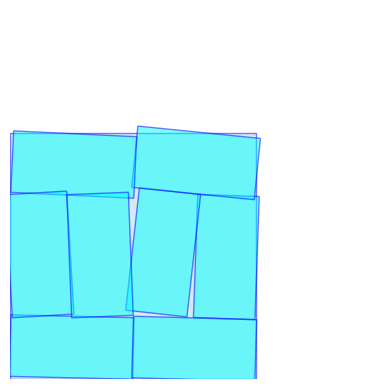

In [ ]:

fig, ax = plt.subplots()
polygon = patches.Polygon(slab, closed=True, fill=True, edgecolor='blue', facecolor='lightblue', alpha=0.5)
ax.add_patch(polygon)

for pos in best_solution:
    rect = patches.Polygon(real_real_cords(pos), closed=True, fill=True, edgecolor='blue', facecolor='cyan', alpha=0.5)
    ax.add_patch(rect)

ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.set_aspect('equal')
ax.grid(True)
ax.set_axis_off()
plt.show()


In [ ]:
def objective(x):
    patterns = [x[i:i+3] for i in range(0, len(x), 3)]
    return func(patterns)

x0 = np.array([coord for pattern in best_solution for coord in pattern])

bounds = [(min_bound[i % 3], max_bound[i % 3]) for i in range(len(x0))]
result = minimize(objective, x0, method='L-BFGS-B', bounds=bounds, options={'maxiter': 100})

improved_solution = [tuple(result.x[i:i+3]) for i in range(0, len(result.x), 3)]
improved_solution = tuple(improved_solution)

print("Improved solution:", improved_solution)
print("Improved fitness:", func(improved_solution))


100%|██████████| 8/8 [00:00<?, ?it/s]

Improved solution: ((np.float64(1.4999992405075033), np.float64(0.49991465852573364), np.float64(6.283182409086597)), (np.float64(0.9999998529570182), np.float64(0.5000404157333509), np.float64(6.283184166184227)), (np.float64(1.9999398763359053), np.float64(1.499899874701195), np.float64(1.570632984910735)), (np.float64(0.0), np.float64(0.4999180067986666), np.float64(4.712551531502037)), (np.float64(1.0000067602289746), np.float64(1.5000421852859007), np.float64(1.5708587517121977)), (np.float64(0.4999237059124871), np.float64(1.500002889618469), np.float64(3.141736099389937)), (np.float64(1.0001728634684532), np.float64(0.5001426317651196), np.float64(4.71206586220963)), (np.float64(0.500080008264788), np.float64(0.500002504679731), np.float64(0.00017242728848372276)))
Improved fitness: 0.00025288626127045256


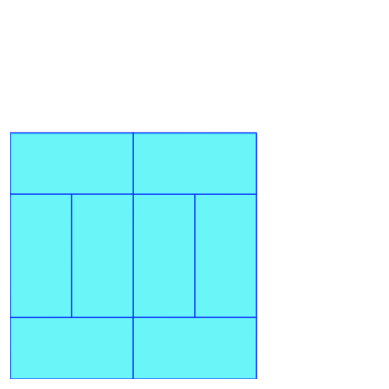

Относителоьное улучшение: 0.997699974481056


In [12]:

# Визуализация улучшенного решения
fig, ax = plt.subplots()
polygon = patches.Polygon(slab, closed=True, fill=True, edgecolor='blue', facecolor='lightblue', alpha=0.5)
ax.add_patch(polygon)

for pos in improved_solution:
    rect = patches.Polygon(real_real_cords(pos), closed=True, fill=True, edgecolor='blue', facecolor='cyan', alpha=0.5)
    ax.add_patch(rect)

ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.set_aspect('equal')
ax.grid(True)
ax.set_axis_off()
plt.show()

print("Относителоьное улучшение:", (func(best_solution) - func(improved_solution))/func(best_solution))